In [ ]:
import torch
import itertools
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
from torchvision import transforms
import torchvision.transforms.functional as F
import random
from tqdm import tqdm
from scipy.ndimage import rotate

In [ ]:
train_data = os.listdir('./Colton AI project/Myositis Images/train_data_tile_10/')
train_label = os.listdir('./Colton AI project/Myositis Images/train_label_tile_10/')

In [ ]:
selected_data = set(['_'.join(_.split('_')[:4]) for _ in train_data])

In [ ]:
np.unique([_[:13] for _ in selected_data], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 37,  8, 33, 52, 23,  9]))

In [ ]:
# train data (121): 121919_Myo089, 121919_Myo253, 121919_Myo368
# validation data (50): 121919_Myo208, 121919_Myo388
# test data (17): 121919_Myo231, 121919_Myo511 

In [ ]:
train_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy') for idx in range(2944)] 
              for _ in selected_data if _[:13] in ['121919_Myo089', '121919_Myo253', '121919_Myo368']]
validation_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy') for idx in range(2944)] 
                   for _ in selected_data if _[:13] in ['121919_Myo208', '121919_Myo388']]
test_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy') for idx in range(2944)] 
             for _ in selected_data if _[:13] in ['121919_Myo231', '121919_Myo511']]
train_list = list(itertools.chain(*train_list))
validation_list = list(itertools.chain(*validation_list))
test_list = list(itertools.chain(*test_list))
print('train data: {}'.format(len(train_list)))
print('validation data: {}'.format(len(validation_list)))
print('test data: {}'.format(len(test_list)))

train data: 356224
validation data: 176640
test data: 50048


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None, rotation=None):
        self.file_list = file_list
        self.transform = transform
        self.rotation = rotation

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        input = np.load('./Colton AI project/Myositis Images/train_data_tile_10/' + '_'.join(self.file_list[idx][0].split('_')[:4]) + '/' 
                        + self.file_list[idx][0])
        target = np.load('./Colton AI project/Myositis Images/train_label_tile_10/' + '_'.join(self.file_list[idx][0].split('_')[:4]) + '/' 
                         + self.file_list[idx][1])
        
        if self.rotation:
            rot = random.uniform(-self.rotation,self.rotation)
            input = rotate(input, rot, reshape=False, order=1)
            target = (rotate(target, rot, reshape=False, order=1) > 0) * 1.
        
        input = torch.from_numpy(input).unsqueeze(0).float()
        target = torch.from_numpy(target).unsqueeze(0).float()

        if self.transform:
            input = self.transform(input)

        return (input, target)

In [ ]:
dataloader = {}
dataloader['train'] = DataLoader(CustomDataset(train_list, rotation=3), batch_size=16, shuffle=True, num_workers=8, drop_last=False)
dataloader['validation'] = DataLoader(CustomDataset(validation_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)
dataloader['test'] = DataLoader(CustomDataset(test_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)

In [ ]:
datasize = {'train': len(train_list), 'validation': len(validation_list), 'test': len(test_list)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

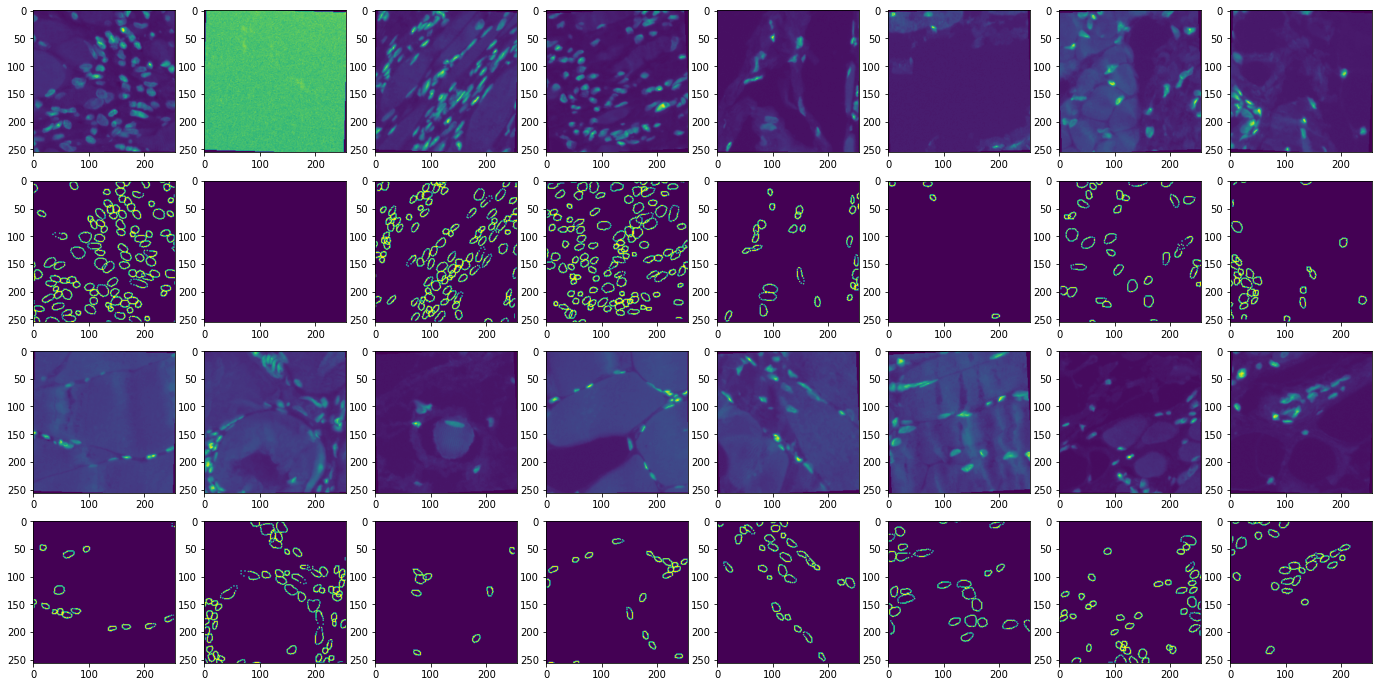

In [ ]:
input, target = next(iter(dataloader['train']))
plt.figure(figsize=(24,12))
for _ in range(8):
  plt.subplot(4,8,_+1)
  plt.imshow(input[_].squeeze().numpy())
  plt.subplot(4,8,_+9)
  plt.imshow(target[_].squeeze().numpy())
for _ in range(8,16):
  plt.subplot(4,8,_+9)
  plt.imshow(input[_].squeeze().numpy())
  plt.subplot(4,8,_+17)
  plt.imshow(target[_].squeeze().numpy())
plt.show()

# DiceLoss + BCELoss

In [ ]:
def train_model(model, criterion1, criterion2, optimizer, scheduler, thres=0.5, num_epochs=25):
    since = time.time()
    
    init_model_wts = copy.deepcopy(model.state_dict())
    best_pos_model_wts = copy.deepcopy(model.state_dict())
    best_neg_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts = copy.deepcopy(model.state_dict())
    best_pos_acc = 0.0
    best_neg_acc = 0.0
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_pos_corrects = 0
            running_neg_corrects = 0
            running_pos = 0
            running_neg = 0

            # Iterate over data.
            for inputs, target in dataloader[phase]:
                inputs = inputs.to(device)
                target = target.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred = (outputs > thres) * 1
                    loss1 = criterion1(outputs, target)
                    loss2 = criterion2(outputs, target)
                    loss = loss1 + loss2

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_pos += torch.sum(target)
                running_neg += torch.sum(~target.bool())
                running_pos_corrects += torch.sum(pred[target.bool()])
                running_neg_corrects += torch.sum(~target.bool()) - torch.sum(pred[~target.bool()])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasize[phase]
            epoch_pos_acc = running_pos_corrects.double() / running_pos.double()
            epoch_neg_acc = running_neg_corrects.double() / running_neg.double()
            epoch_acc = (epoch_pos_acc + epoch_neg_acc) / 2

            print('{} Loss: {:.4f} Boundary Acc: {:.4f} Background Acc: {:.4f} Overall Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_pos_acc, epoch_neg_acc, epoch_acc))

            # deep copy the model
            if phase == 'validation':
                if epoch_pos_acc > best_pos_acc:
                    best_pos_acc = epoch_pos_acc
                    best_pos_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss1': criterion1.state_dict(), 
                                'loss2': criterion2.state_dict(), 'thres': thres, 'epoch': epoch, 'initial_state': init_model_wts}, 
                               './Colton AI project/Myositis Images/model_tile/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(epoch_pos_acc, epoch_neg_acc))
                if epoch_neg_acc > best_neg_acc:
                    best_neg_acc = epoch_neg_acc
                    best_neg_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss1': criterion1.state_dict(), 
                                'loss2': criterion2.state_dict(), 'thres': thres, 'epoch': epoch, 'initial_state': init_model_wts}, 
                               './Colton AI project/Myositis Images/model_tile/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(epoch_pos_acc, epoch_neg_acc))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss1': criterion1.state_dict(), 
                                'loss2': criterion2.state_dict(), 'thres': thres, 'epoch': epoch, 'initial_state': init_model_wts}, 
                               './Colton AI project/Myositis Images/model_tile/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(epoch_pos_acc, epoch_neg_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Boundary Acc: {:4f}, Best Background Acc: {:4f}, Best Overall Acc: {:4f}'.format(best_pos_acc, best_neg_acc, best_acc))

In [ ]:
class DiceLoss(nn.Module):
    # reduction = 'sum'
    def __init__(self, device):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0
        self.one = torch.ones(1, requires_grad=True, device=device)

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return self.one - dsc

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model = model.to(device)
criterion1 = DiceLoss(device)
criterion2 = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor([33.]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Using cache found in /home/fz477/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
train_model(model, criterion1, criterion2, optimizer, scheduler)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------
train Loss: 82801.7879 Boundary Acc: 0.9650 Background Acc: 0.9186 Overall Acc: 0.9418
validation Loss: 60641.5162 Boundary Acc: 0.9784 Background Acc: 0.8939 Overall Acc: 0.9361


  4%|▍         | 1/25 [1:31:30<36:36:21, 5490.88s/it]


Epoch 1/24
----------
train Loss: 81760.6135 Boundary Acc: 0.9786 Background Acc: 0.9308 Overall Acc: 0.9547
validation Loss: 60585.8759 Boundary Acc: 0.9664 Background Acc: 0.8993 Overall Acc: 0.9328


  8%|▊         | 2/25 [3:01:34<34:54:48, 5464.71s/it]


Epoch 2/24
----------
train Loss: 81391.8505 Boundary Acc: 0.9825 Background Acc: 0.9361 Overall Acc: 0.9593
validation Loss: 60452.0204 Boundary Acc: 0.9647 Background Acc: 0.9032 Overall Acc: 0.9339


 12%|█▏        | 3/25 [4:29:41<33:04:08, 5411.31s/it]


Epoch 3/24
----------
train Loss: 81187.9720 Boundary Acc: 0.9845 Background Acc: 0.9393 Overall Acc: 0.9619


 16%|█▌        | 4/25 [5:57:03<31:16:10, 5360.49s/it]

validation Loss: 60475.8336 Boundary Acc: 0.9693 Background Acc: 0.9011 Overall Acc: 0.9352

Epoch 4/24
----------
train Loss: 81047.3949 Boundary Acc: 0.9857 Background Acc: 0.9416 Overall Acc: 0.9637


 20%|██        | 5/25 [7:24:56<29:38:06, 5334.32s/it]

validation Loss: 60559.1132 Boundary Acc: 0.9634 Background Acc: 0.9010 Overall Acc: 0.9322

Epoch 5/24
----------
train Loss: 80829.7531 Boundary Acc: 0.9876 Background Acc: 0.9453 Overall Acc: 0.9664
validation Loss: 60458.5865 Boundary Acc: 0.9603 Background Acc: 0.9047 Overall Acc: 0.9325


 24%|██▍       | 6/25 [8:51:59<27:58:35, 5300.82s/it]


Epoch 6/24
----------
train Loss: 80778.5027 Boundary Acc: 0.9880 Background Acc: 0.9461 Overall Acc: 0.9671


 28%|██▊       | 7/25 [10:18:02<26:17:52, 5259.58s/it]

validation Loss: 60479.4961 Boundary Acc: 0.9604 Background Acc: 0.9041 Overall Acc: 0.9323

Epoch 7/24
----------
train Loss: 80750.9498 Boundary Acc: 0.9882 Background Acc: 0.9466 Overall Acc: 0.9674


 32%|███▏      | 8/25 [11:48:01<25:02:06, 5301.57s/it]

validation Loss: 60475.0558 Boundary Acc: 0.9592 Background Acc: 0.9046 Overall Acc: 0.9319

Epoch 8/24
----------


# visualize dice loss + BCELoss model

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=1, out_channels=1, init_features=32, pretrained=False) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('./Colton AI project/Myositis Images/model_tile/unet_fa_{:.3f}_ba_{:.3f}.pt'.format(0.880, 0.954), map_location=device)
model = model_load['model'].to(device)

Using cache found in /home/fz477/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
data_file = os.listdir('./Colton AI project/Myositis Images/CD27 Panel-- Component')
label_file = os.listdir('./Colton AI project/Myositis Images/Labels/CD27 cell labels')
label_file.remove('Bounding Rectangle')

In [ ]:
selected_data = set([_[:-9] for _ in data_file]).intersection(set([_[:-11] for _ in label_file]))
print(len(selected_data))

198


In [ ]:
train_data = os.listdir('./Colton AI project/Myositis Images/train_data/')
train_label = os.listdir('./Colton AI project/Myositis Images/train_label/')

In [ ]:
selected_data = set(['_'.join(_.split('_')[:4]) for _ in train_data])

In [ ]:
np.unique([_[:13] for _ in selected_data], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 27,  8, 33, 52, 23,  9]))

In [ ]:
train_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy') for idx in range(48)] 
              for _ in selected_data if _[:13] in ['121919_Myo089', '121919_Myo253', '121919_Myo368']]
validation_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy') for idx in range(48)] 
                   for _ in selected_data if _[:13] in ['121919_Myo208', '121919_Myo388']]
test_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy') for idx in range(48)] 
             for _ in selected_data if _[:13] in ['121919_Myo231', '121919_Myo511']]
train_list = list(itertools.chain(*train_list))
validation_list = list(itertools.chain(*validation_list))
test_list = list(itertools.chain(*test_list))
print('train data: {}'.format(len(train_list)))
print('validation data: {}'.format(len(validation_list)))
print('test data: {}'.format(len(test_list)))

train data: 5808
validation data: 2400
test data: 816


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        input = np.load('./Colton AI project/Myositis Images/train_data/' + self.file_list[idx][0])
        target = np.load('./Colton AI project/Myositis Images/train_label/' + self.file_list[idx][1])
        input = torch.from_numpy(input).unsqueeze(0)
        target = torch.from_numpy(target).unsqueeze(0)

        if self.transform:
            input = self.transform(input)

        return (input, target)

In [ ]:
dataloader = {}
dataloader['train'] = DataLoader(CustomDataset(train_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)
dataloader['validation'] = DataLoader(CustomDataset(validation_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)
dataloader['test'] = DataLoader(CustomDataset(test_list), batch_size=16, shuffle=True, num_workers=8, drop_last=False)

In [ ]:
datasize = {'train': len(train_list), 'validation': len(validation_list), 'test': len(test_list)}

In [ ]:
model.eval()   # Set model to evaluate mode

running_pos_corrects = 0
running_neg_corrects = 0
running_pos = 0
running_neg = 0

# Iterate over data.
for inputs, target in dataloader['validation']:
    inputs = inputs.to(device)
    target = target.to(device)

    outputs = model(inputs)
    pred = outputs > 0.8

    # statistics
    running_pos += torch.sum(target)
    running_neg += torch.sum(~target.bool())
    running_pos_corrects += torch.sum(pred[target.bool()])
    running_neg_corrects += torch.sum(~target.bool()) - torch.sum(pred[~target.bool()])

epoch_pos_acc = running_pos_corrects.double() / running_pos.double()
epoch_neg_acc = running_neg_corrects.double() / running_neg.double()
epoch_acc = (epoch_pos_acc + epoch_neg_acc) / 2
print('Validation Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_pos_acc, epoch_neg_acc, epoch_acc))

Validation Boundary Acc: 0.880041, Background Acc: 0.953835, Overall Acc: 0.916938


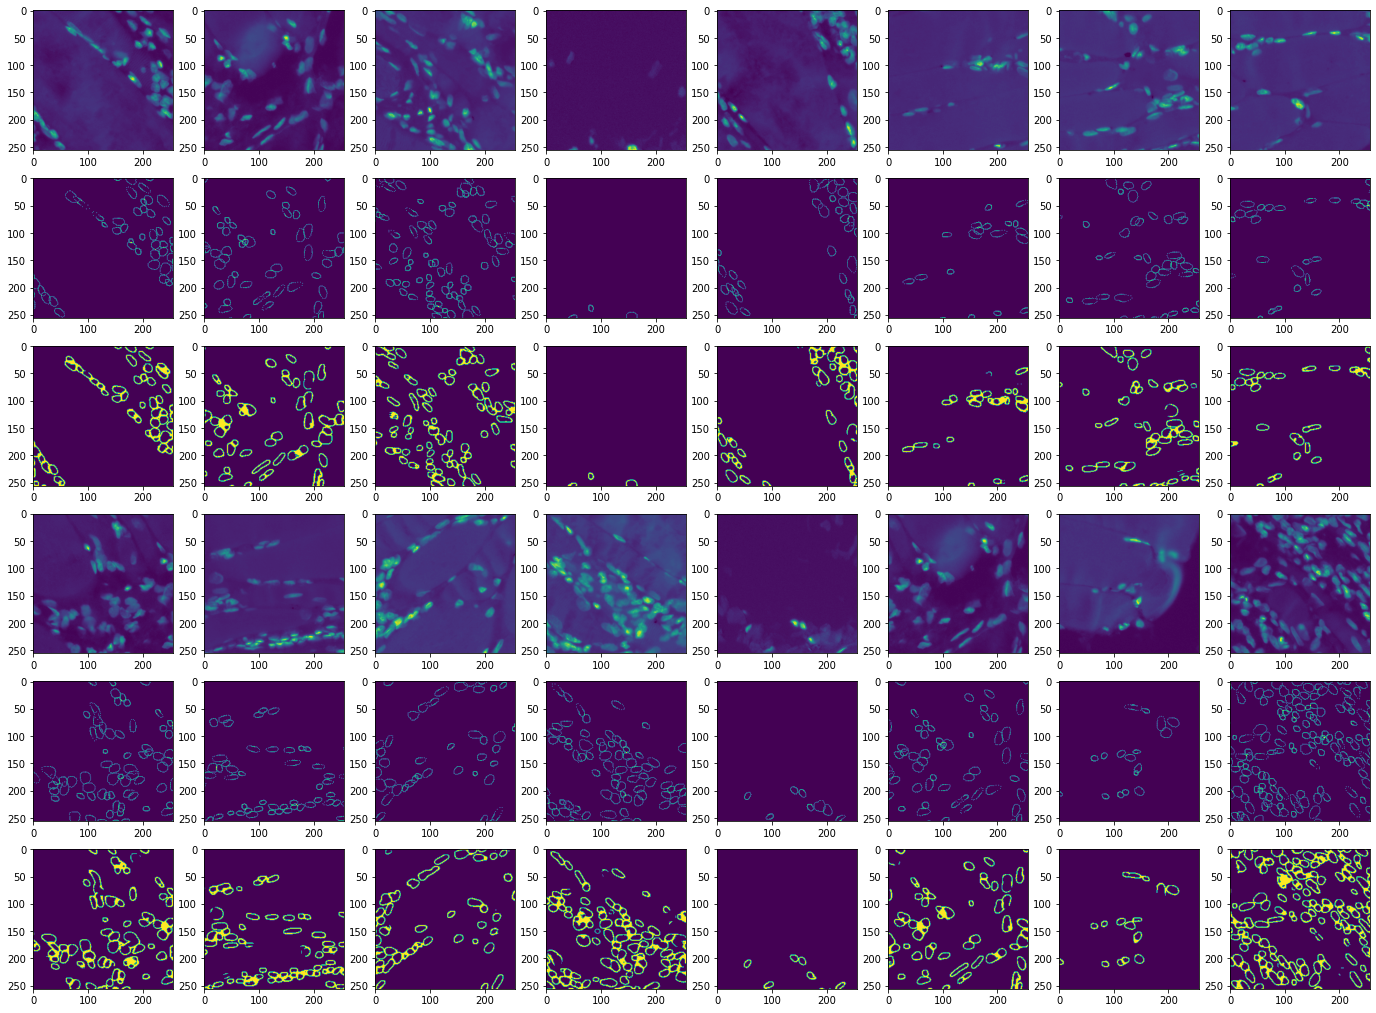

In [ ]:
input, target = next(iter(dataloader['validation']))
output = model.cpu()(input)
output = (output > 0.8).float()

plt.figure(figsize=(24,18))
for _ in range(8):
  plt.subplot(6,8,_+1)
  plt.imshow(input[_].squeeze().numpy())
  plt.subplot(6,8,_+9)
  plt.imshow(target[_].squeeze().numpy())
  plt.subplot(6,8,_+17)
  plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
  plt.subplot(6,8,_+17)
  plt.imshow(input[_].squeeze().numpy())
  plt.subplot(6,8,_+25)
  plt.imshow(target[_].squeeze().numpy())
  plt.subplot(6,8,_+33)
  plt.imshow(output[_].squeeze().numpy())
plt.show()

In [ ]:
model = model_load['model'].to(device)
model.eval()   # Set model to evaluate mode

running_pos_corrects = 0
running_neg_corrects = 0
running_pos = 0
running_neg = 0

# Iterate over data.
for inputs, target in dataloader['test']:
    inputs = inputs.to(device)
    target = target.to(device)

    outputs = model(inputs)
    pred = outputs > 0.8

    # statistics
    running_pos += torch.sum(target)
    running_neg += torch.sum(~target.bool())
    running_pos_corrects += torch.sum(pred[target.bool()])
    running_neg_corrects += torch.sum(~target.bool()) - torch.sum(pred[~target.bool()])

epoch_pos_acc = running_pos_corrects.double() / running_pos.double()
epoch_neg_acc = running_neg_corrects.double() / running_neg.double()
epoch_acc = (epoch_pos_acc + epoch_neg_acc) / 2
print('Test Boundary Acc: {:4f}, Background Acc: {:4f}, Overall Acc: {:4f}'.format(epoch_pos_acc, epoch_neg_acc, epoch_acc))

Test Boundary Acc: 0.859354, Background Acc: 0.976843, Overall Acc: 0.918099


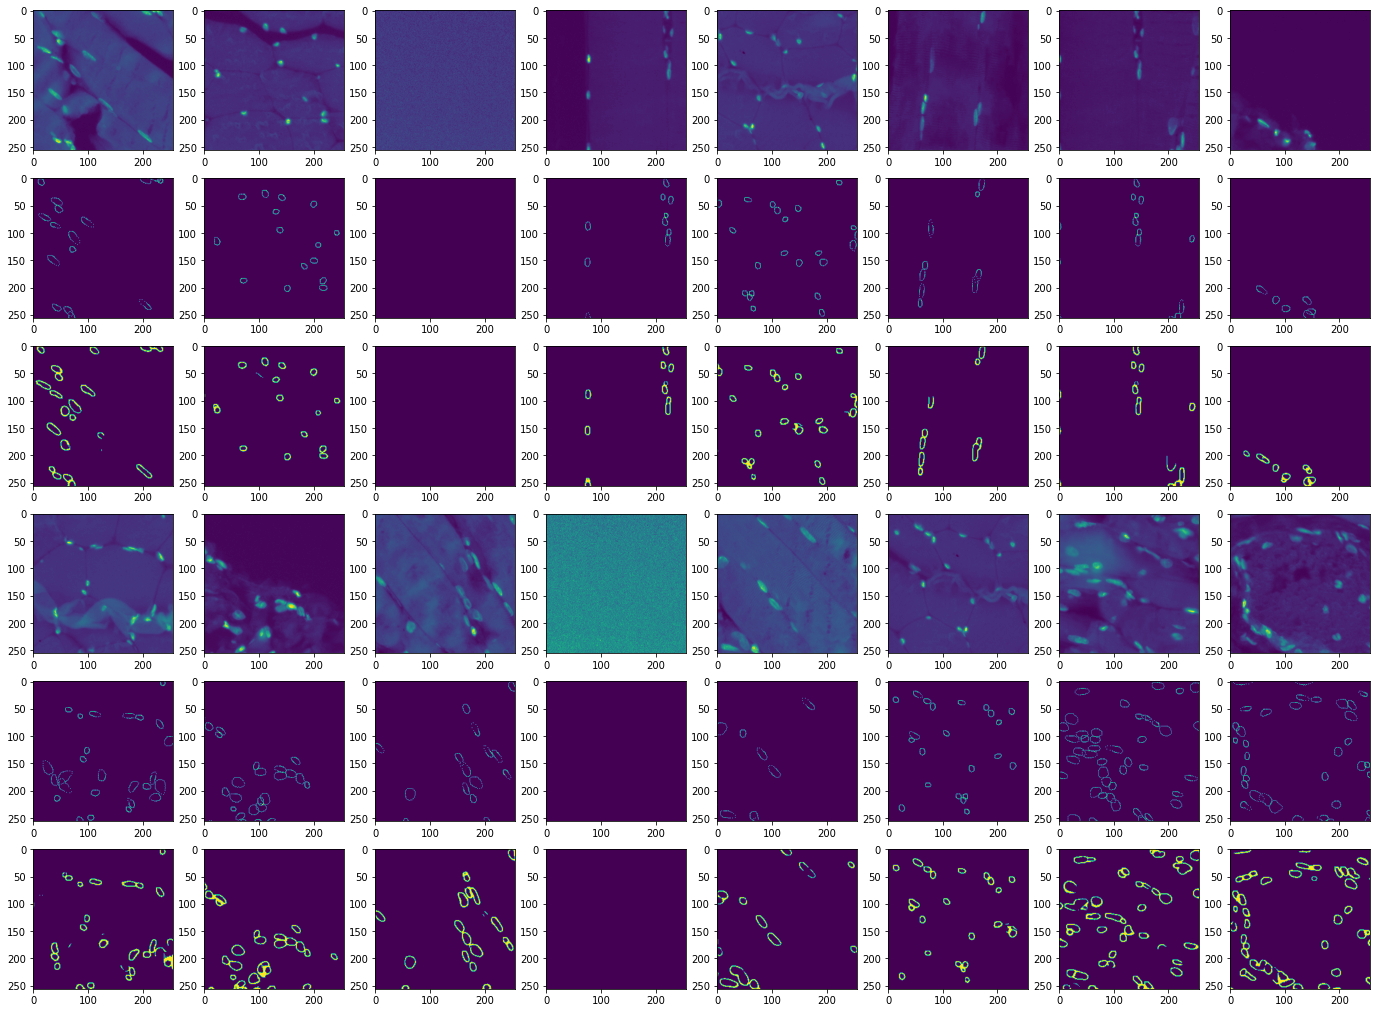

In [ ]:
input, target = next(iter(dataloader['test']))
output = model.cpu()(input)
output = (output > 0.8).float()

plt.figure(figsize=(24,18))
for _ in range(8):
  plt.subplot(6,8,_+1)
  plt.imshow(input[_].squeeze().numpy())
  plt.subplot(6,8,_+9)
  plt.imshow(target[_].squeeze().numpy())
  plt.subplot(6,8,_+17)
  plt.imshow(output[_].squeeze().numpy())
for _ in range(8,16):
  plt.subplot(6,8,_+17)
  plt.imshow(input[_].squeeze().numpy())
  plt.subplot(6,8,_+25)
  plt.imshow(target[_].squeeze().numpy())
  plt.subplot(6,8,_+33)
  plt.imshow(output[_].squeeze().numpy())
plt.show()